# Entrainement - Set vins

## Abstract

L'analyse conduite sur les outliers et la suppression des colonnes idoines d'une part et la définition d'une nouvelle variable par clustering d'autre part permet de maximiser le score d'algortihme de ML et DL

## Bibliothèques utilisées

In [1]:
#Generique
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# reduction dimension
from sklearn.feature_selection import VarianceThreshold,RFE,RFECV,SelectKBest,f_regression

# ML
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from scipy.cluster.hierarchy  import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# DL
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Dropout
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

### Instanciation données

In [2]:
df = pd.read_csv('WineQT.csv')

### Revue de base:
- Revue sur variables
- Revue des doublons
- Visibilité NAN


Une vue d'ensemble des données

In [3]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,1
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,2
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,3
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,1592
1139,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6,1593
1140,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,1594
1141,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,1595


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


Que représente la variable Id ?

In [5]:
df.Id.value_counts()

0       1
1079    1
1087    1
1086    1
1085    1
       ..
543     1
544     1
545     1
546     1
1597    1
Name: Id, Length: 1143, dtype: int64

Il y a autant d'ID que d'entrée -> Il apparait ainsi que cette variable  n'apporte pas d'info pertinente sur le jeu de donnée, il convient de la supprimer

In [6]:
df = df.drop(['Id'],axis = 1)

A ce stade, il ne parait pas opportun de supprimer davantage de variable

Présence de doublons ?

In [7]:
df.duplicated().sum()

125

Note : il est intéressant de constater qu'il ya présence de doublons et que l'on vient de supprimer une variable pour laquelle chaque entrée présente une valeur distincte. Ainsi, si nous avions pratiqué l'analyse des doublons en amont, nous serions passé à côté de cette info dans la mesure où aucun doublon n'aurait été détecté.

On procède à l'élimination des doublons et l'on confirme

In [8]:
df = df.drop_duplicates()

In [9]:
df.duplicated().sum()

0

Présence de NaN ?

In [10]:
NAN = pd.DataFrame({'Count':df.isna().sum()})
NAN

,Count
fixed acidity,0
volatile acidity,0
citric acid,0
residual sugar,0
chlorides,0
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,0
sulphates,0


### Revue statistique:

In [11]:
stat = round(df.describe(),3)
stat

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1018.000,1018.000,1018.000,1018.000,1018.000,1018.000,1018.000,1018.000,1018.000,1018.000,1018.000,1018.000
mean,8.289,0.534,0.269,2.524,0.087,15.649,46.326,0.997,3.312,0.657,10.452,5.641
std,1.741,0.183,0.196,1.315,0.049,10.177,33.124,0.002,0.158,0.168,1.095,0.812
min,4.600,0.120,0.000,0.900,0.012,1.000,6.000,0.990,2.740,0.330,8.400,3.000
25%,7.100,0.390,0.090,1.900,0.070,7.000,21.000,0.996,3.210,0.550,9.500,5.000
50%,7.900,0.520,0.250,2.200,0.079,13.000,38.000,0.997,3.310,0.620,10.200,6.000
75%,9.100,0.645,0.420,2.600,0.090,21.000,62.000,0.998,3.400,0.720,11.200,6.000
max,15.900,1.580,1.000,15.500,0.611,68.000,289.000,1.004,4.010,2.000,14.900,8.000


On affiche la distribution en diagramme boite à moustache afin de vérifier la présence de valeurs aberrantes:

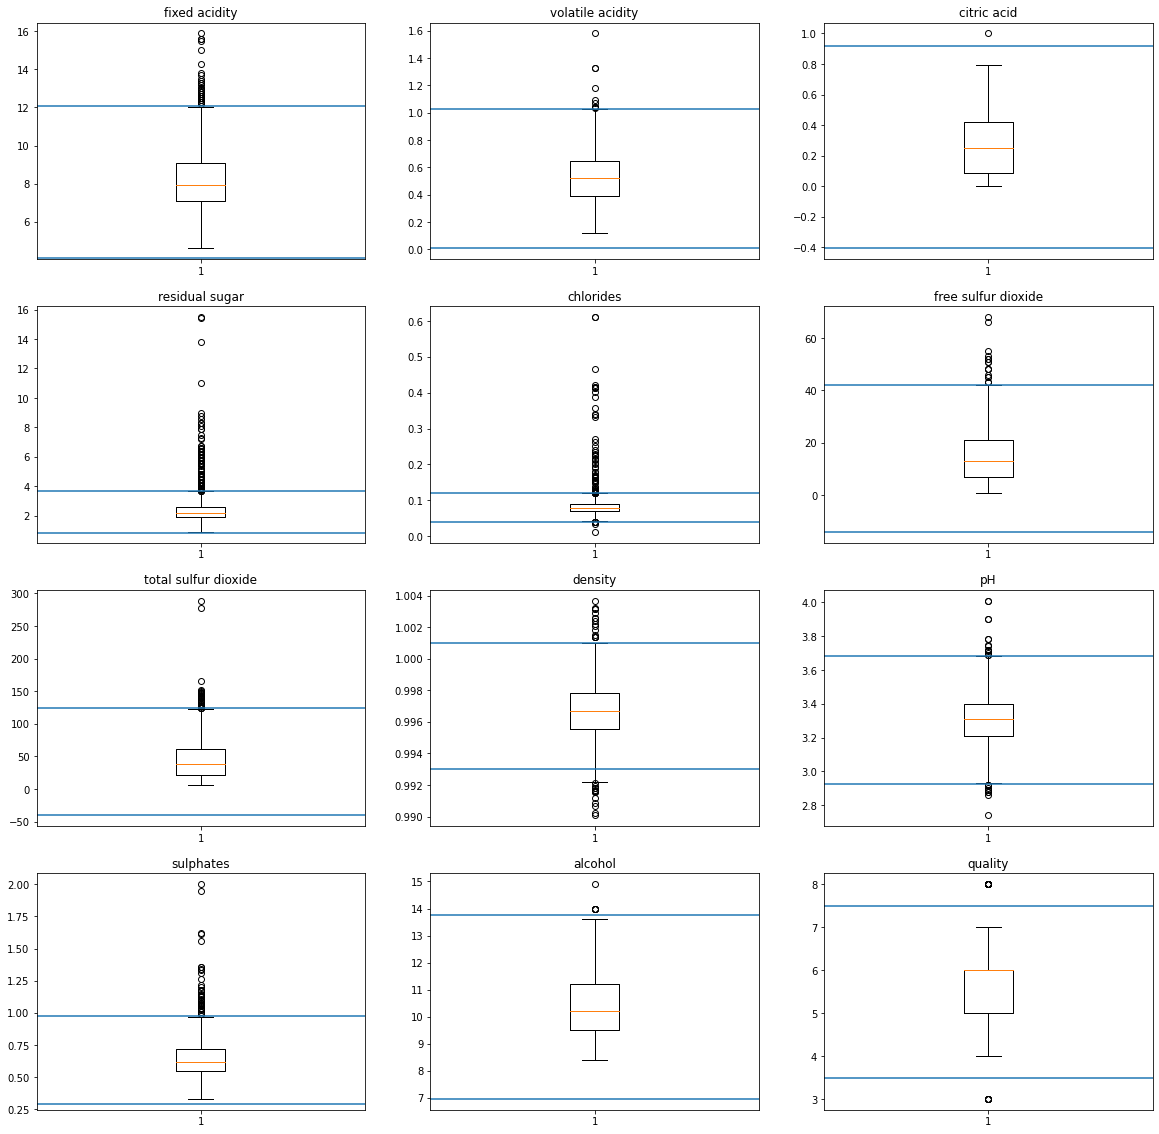

In [12]:
plt.figure(figsize=(20,20))

for k in range(0,len(df.columns)):
    plt.subplot(4,3,k+1)
    plt.boxplot(df[df.columns[k]])
    plt.title(f'{df.columns[k]}')
    Q3 = stat.loc['75%',df.columns[k]]
    Q1 = stat.loc['25%',df.columns[k]]
    borne_sup = Q3+1.5*(Q3-Q1)
    borne_inf = Q1-1.5*(Q3-Q1)
    plt.axhline(y=borne_sup)
    plt.axhline(y=borne_inf)
        
plt.show()

On considère qu'une valeur est abérrante si elle est au delà ou en deça, respectivement de Q3 + 1.5 x (Q3-Q1) et Q1 - 1.5 x (Q3 - Q1), matérialisé sur les graphes précédants par les deux lignes horizontales bleues.

On propose de créer un dataset miroir où chaque outlier sera codé à 1 de façon à pouvoir par la suite statuer sur les actions à entreprendre vis-à-vis des données.

In [13]:
miroir = df.copy()

On crée une fonction qui permet de présenter l'information outlier

In [14]:
def outlier(x,i):
    Q3 = stat.loc['75%',df.columns[i]]
    Q1 = stat.loc['25%',df.columns[i]]
    borne_sup = Q3+1.5*(Q3-Q1)
    borne_inf = Q1-1.5*(Q3-Q1)
    
    if x > borne_sup or x < borne_inf:
        return 1
    else: 
        return 0

On applique cette fonction à l'ensemble du dataframe

In [15]:
for i in range(len(df.columns)):
    miroir[df.columns[i]] = miroir[df.columns[i]].apply(lambda x: outlier(x,i))

In [16]:
miroir

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1138,0,0,0,0,0,0,0,0,0,0,0,0
1139,0,0,0,0,0,0,0,0,0,0,0,0
1140,0,0,0,0,0,0,0,0,0,0,0,0
1141,0,0,0,0,0,0,0,0,0,0,0,0


On présente les résultats dans un dataframe

In [17]:
liste_0 =[]
liste_1 =[]

for i in range(len(df.columns)):
    liste_0.append(miroir[df.columns[i]].value_counts()[0])
    liste_1.append(miroir[df.columns[i]].value_counts()[1])

visu = pd.DataFrame({0:liste_0,1:liste_1},index = df.columns)
visu['%'] = round(100*visu[1]/(visu[1]+visu[0]),2)
visu

,0,1,%
fixed acidity,981,37,3.63
volatile acidity,1008,10,0.98
citric acid,1017,1,0.10
residual sugar,923,95,9.33
chlorides,947,71,6.97
free sulfur dioxide,1002,16,1.57
total sulfur dioxide,985,33,3.24
density,971,47,4.62
pH,994,24,2.36
sulphates,977,41,4.03


La proportion de valeur aberrante est plutot faible à l'exception des variables 'residual sugar' et 'chlorides'

On cherche à présent à savoir comment sont distribuées ces valeurs abérrantes dans le dataset 

In [18]:
miroir['somme'] = miroir.sum(axis = 1)

In [19]:
miroir.somme.value_counts()

0    731
1    205
2     59
3     13
4     10
Name: somme, dtype: int64

On apprend ainsi que 731 entrées ne présentent aucune valeurs abérrantes et 205 entrées seulement 1 valeur aberrante

In [20]:
miroir_bis = miroir.drop(['residual sugar','chlorides','somme'],axis = 1)
miroir_bis['somme'] = miroir_bis.sum(axis = 1)
miroir_bis.somme.value_counts()

0    829
1    151
2     30
3      7
4      1
Name: somme, dtype: int64

On constate qu'en supprimant les variables à relativement "forte" présence de valeurs abérrantes,i.e "Chloride" et residual sugar" ainsi que les lignes présentant au moins 1 valeur abérrante, on dispose d'un jeu de donnée représentant 81% du jeu de donnée initiale sans valeurs abérrantes contre 71%  si on garde toutes les variables

- Afin de tendre vers un modèle statistiquement robuste, les choix suivants sont réalisés:
    - suppression des variables "Chlorides" et "residual sugar"
    - suppression de toute entrée présentant au moins une valeur abérrante

In [21]:
to_suppr = miroir_bis[miroir_bis['somme']>=1].index

In [22]:
df = df.drop(['residual sugar','chlorides'],axis = 1)

In [23]:
df = df.drop(to_suppr)

In [24]:
df

,fixed acidity,volatile acidity,citric acid,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,17.0,60.0,0.99800,3.16,0.58,9.8,6
5,7.4,0.660,0.00,13.0,40.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...
1138,6.3,0.510,0.13,29.0,40.0,0.99574,3.42,0.75,11.0,6
1139,6.8,0.620,0.08,28.0,38.0,0.99651,3.42,0.82,9.5,6
1140,6.2,0.600,0.08,32.0,44.0,0.99490,3.45,0.58,10.5,5
1141,5.9,0.550,0.10,39.0,51.0,0.99512,3.52,0.76,11.2,6


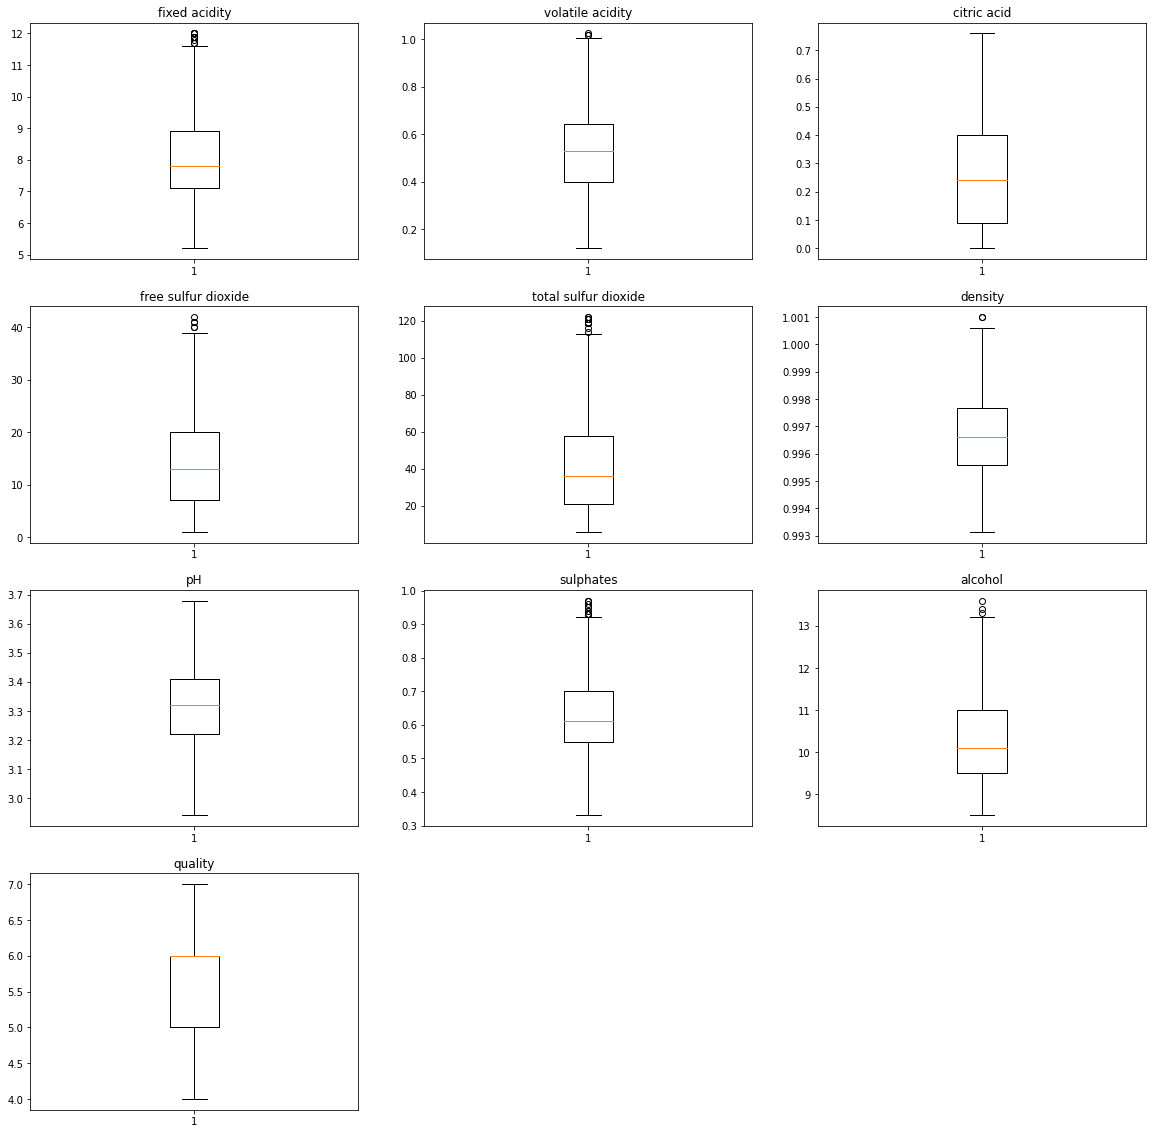

In [25]:
plt.figure(figsize=(20,20))

for k in range(0,len(df.columns)):
    plt.subplot(4,3,k+1)
    plt.boxplot(df[df.columns[k]])
    plt.title(f'{df.columns[k]}')
        
plt.show()

### Essai de modèles:

Définition des features / target

On imagine que la variable pertinente à prédire ici est la qualité

In [26]:
features = df.drop(['quality'],axis = 1)
target = df['quality']

Préparation / normalisation des données

In [27]:
X_train,X_test,y_train,y_test = train_test_split(features,target,test_size = 0.2)

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

MODEL N°1 - REGRESSION LOGISTIQUE

In [28]:
logreg = LogisticRegression()
logreg.fit(X_train_scaled,y_train)
logreg.score(X_test_scaled,y_test)

0.6566265060240963

MODEL N°1_bis - REGRESSION LOGISTIQUE - optimisé

In [29]:
clf_lr = LogisticRegression()
params_lr = {'solver':['liblinear','lbfgs','newton-cg','saga'],'C' :[10**(i) for i in range(-4,5)]}

gridcv = GridSearchCV(clf_lr,param_grid =params_lr,scoring = 'accuracy',cv = 5)

grille = gridcv.fit(X_train_scaled,y_train)
grille.score(X_test_scaled,y_test)

0.6566265060240963

MODEL N°2 - KNN

In [30]:
K7NN = neighbors.KNeighborsClassifier(n_neighbors=7,metric ='minkowski')
K7NN.fit(X_train_scaled,y_train)
K7NN.score(X_test_scaled,y_test)

0.608433734939759

MODEL N°2_bis - KNN optimisé

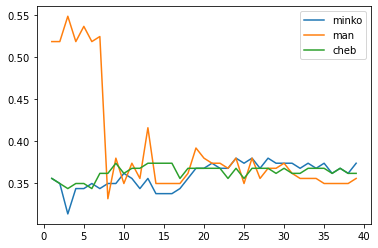

In [31]:
score_minko = []
score_man =[]
score_cheb =[]

meta = [score_minko,score_man,score_cheb]

termes =['minkowski','manhattan','chebyshev']

for i,terme in enumerate(termes):
    for k in range(1,40):
        knn = neighbors.KNeighborsClassifier(n_neighbors=k,metric =terme)
        knn.fit(X_train_scaled,y_train)
        y_pred = knn.predict(X_test)
        score =accuracy_score(y_test,y_pred)
        meta[i].append(score)
        
k = [i for i in range(1,40)]

plt.plot(k,score_minko,label ='minko')
plt.plot(k,score_man,label ='man')
plt.plot(k,score_cheb,label = 'cheb')
plt.legend()
plt.show()

In [32]:
np.argmax(score_man)

2

In [33]:
K6NN = neighbors.KNeighborsClassifier(n_neighbors=np.argmax(score_man),metric ='manhattan')
K6NN.fit(X_train_scaled,y_train)
K6NN.score(X_test_scaled,y_test)

0.5120481927710844

La démarche d'optimisation n'est pas fructueuse

MODEL N°x - RESEAU NEURONNE DENSE

In [34]:
model = Sequential()

model.add(tf.keras.Input(shape =(9)))

model.add(Dense(124,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(124,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(528,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(124,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(10,activation ='softmax'))

model.compile(loss =tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="auto", name="sparse_categorical_crossentropy"
),optimizer ='adam',metrics = 'accuracy')

epok = 50

training_history = model.fit(X_train_scaled,y_train,validation_data=(X_test_scaled,y_test),batch_size =10,epochs = epok)


Epoch 1/50
67/67 [==============================] - 1s 5ms/step - loss: 1.2155 - accuracy: 0.5158 - val_loss: 0.9107 - val_accuracy: 0.6205
Epoch 2/50
67/67 [==============================] - 0s 3ms/step - loss: 0.9497 - accuracy: 0.5732 - val_loss: 0.8905 - val_accuracy: 0.5843
Epoch 3/50
67/67 [==============================] - 0s 2ms/step - loss: 0.9069 - accuracy: 0.5867 - val_loss: 0.8680 - val_accuracy: 0.5843
Epoch 4/50
67/67 [==============================] - 0s 2ms/step - loss: 0.8781 - accuracy: 0.6018 - val_loss: 0.8422 - val_accuracy: 0.6325
Epoch 5/50
67/67 [==============================] - 0s 2ms/step - loss: 0.8743 - accuracy: 0.5852 - val_loss: 0.8828 - val_accuracy: 0.5964
Epoch 6/50
67/67 [==============================] - 0s 2ms/step - loss: 0.8615 - accuracy: 0.6018 - val_loss: 0.8490 - val_accuracy: 0.6084
Epoch 7/50
67/67 [==============================] - 0s 2ms/step - loss: 0.8436 - accuracy: 0.6078 - val_loss: 0.8205 - val_accuracy: 0.6807
Epoch 8/50
67/67 [==

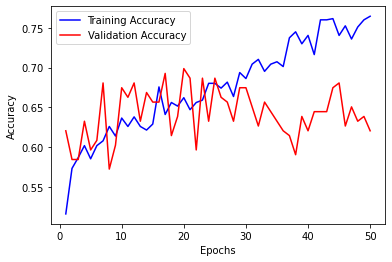

In [35]:
train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.plot(np.arange(1,epok +1,1),training_history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(np.arange(1,epok +1,1),training_history.history['val_accuracy'], label='Validation Accuracy', color='red')

plt.legend()

plt.show()

Un score si bas s'explique peut-être par la mauvaise définition de la variable "quality" ?

## Seconde APPROCHE 

On va " laisser " le jeu de donnée définir le nombre de catégorie pertinente, par clustering

Il nous faut en premier lieu déterminer le nombre optimal de cluster

In [36]:
range_n_clusters =[2,3,4,5,6,7]
s_scores =[]

for n_cluster in range_n_clusters:
    cluster = AgglomerativeClustering(n_clusters = n_cluster)
    cluster.fit(features)
    labels = cluster.labels_
    s_score = silhouette_score(df,labels,metric ='euclidean')
    s_scores.append(s_score)

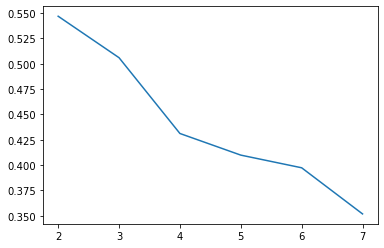

In [37]:
plt.plot(range_n_clusters,s_scores)

Il apparait que 2 semble un nombre optimal de classe pour ce problème. 

On procède à une classification non supervisée de sorte à produire une nouvelle variable 'LABEL' que l'on associera au jeu de donnée

In [38]:
cluster = AgglomerativeClustering(n_clusters = 2)
cluster.fit(features)
labels = cluster.labels_

LABEL = pd.Series(labels)

df_new = pd.concat([df.reset_index().drop(['index'],axis = 1),LABEL],axis=  1).rename(columns={0:'LABEL'})

df_new


,fixed acidity,volatile acidity,citric acid,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,LABEL
0,7.4,0.700,0.00,11.0,34.0,0.99780,3.51,0.56,9.4,5,1
1,7.8,0.880,0.00,25.0,67.0,0.99680,3.20,0.68,9.8,5,0
2,7.8,0.760,0.04,15.0,54.0,0.99700,3.26,0.65,9.8,5,0
3,11.2,0.280,0.56,17.0,60.0,0.99800,3.16,0.58,9.8,6,0
4,7.4,0.660,0.00,13.0,40.0,0.99780,3.51,0.56,9.4,5,1
...,...,...,...,...,...,...,...,...,...,...,...
824,6.3,0.510,0.13,29.0,40.0,0.99574,3.42,0.75,11.0,6,0
825,6.8,0.620,0.08,28.0,38.0,0.99651,3.42,0.82,9.5,6,0
826,6.2,0.600,0.08,32.0,44.0,0.99490,3.45,0.58,10.5,5,0
827,5.9,0.550,0.10,39.0,51.0,0.99512,3.52,0.76,11.2,6,0


On prépare à nouveau le jeu de donnée

In [39]:
FEATURES = df_new.drop(['LABEL','quality'],axis = 1)
TARGET = df_new['LABEL']

X_TRAIN,X_TEST,Y_TRAIN,Y_TEST = train_test_split(FEATURES,TARGET,test_size = 0.2)

scaler = preprocessing.StandardScaler().fit(X_TRAIN)
X_TRAIN_SCALED = scaler.transform(X_TRAIN)
X_TEST_SCALED = scaler.transform(X_TEST)

In [40]:
FEATURES

,fixed acidity,volatile acidity,citric acid,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.700,0.00,11.0,34.0,0.99780,3.51,0.56,9.4
1,7.8,0.880,0.00,25.0,67.0,0.99680,3.20,0.68,9.8
2,7.8,0.760,0.04,15.0,54.0,0.99700,3.26,0.65,9.8
3,11.2,0.280,0.56,17.0,60.0,0.99800,3.16,0.58,9.8
4,7.4,0.660,0.00,13.0,40.0,0.99780,3.51,0.56,9.4
...,...,...,...,...,...,...,...,...,...
824,6.3,0.510,0.13,29.0,40.0,0.99574,3.42,0.75,11.0
825,6.8,0.620,0.08,28.0,38.0,0.99651,3.42,0.82,9.5
826,6.2,0.600,0.08,32.0,44.0,0.99490,3.45,0.58,10.5
827,5.9,0.550,0.10,39.0,51.0,0.99512,3.52,0.76,11.2


On essaie à nouveau un modèle de régression logistique

In [41]:
LOGREG = LogisticRegression()
LOGREG.fit(X_TRAIN_SCALED,Y_TRAIN)
LOGREG.score(X_TEST_SCALED,Y_TEST)

0.9578313253012049

In [42]:
MODEL = Sequential()

MODEL.add(tf.keras.Input(shape =(9)))

MODEL.add(Dense(124,activation = 'relu'))
MODEL.add(Dropout(0.2))
MODEL.add(Dense(124,activation = 'relu'))
MODEL.add(Dropout(0.2))
MODEL.add(Dense(528,activation = 'relu'))
MODEL.add(Dropout(0.2))
MODEL.add(Dense(124,activation = 'relu'))
MODEL.add(Dropout(0.2))
MODEL.add(Dense(1,activation ='sigmoid'))

MODEL.compile(loss ="binary_crossentropy",optimizer ='adam',metrics = 'binary_accuracy')

epok = 50

training_history = MODEL.fit(X_TRAIN_SCALED,Y_TRAIN,validation_data=(X_TEST_SCALED,Y_TEST),batch_size =10,epochs = epok)


Epoch 1/50
67/67 [==============================] - 1s 6ms/step - loss: 0.2560 - binary_accuracy: 0.8808 - val_loss: 0.0812 - val_binary_accuracy: 0.9759
Epoch 2/50
67/67 [==============================] - 0s 2ms/step - loss: 0.1032 - binary_accuracy: 0.9563 - val_loss: 0.0779 - val_binary_accuracy: 0.9639
Epoch 3/50
67/67 [==============================] - 0s 2ms/step - loss: 0.0736 - binary_accuracy: 0.9638 - val_loss: 0.1372 - val_binary_accuracy: 0.9458
Epoch 4/50
67/67 [==============================] - 0s 2ms/step - loss: 0.0843 - binary_accuracy: 0.9713 - val_loss: 0.0702 - val_binary_accuracy: 0.9639
Epoch 5/50
67/67 [==============================] - 0s 2ms/step - loss: 0.0585 - binary_accuracy: 0.9744 - val_loss: 0.0630 - val_binary_accuracy: 0.9699
Epoch 6/50
67/67 [==============================] - 0s 2ms/step - loss: 0.0531 - binary_accuracy: 0.9789 - val_loss: 0.0661 - val_binary_accuracy: 0.9699
Epoch 7/50
67/67 [==============================] - 0s 2ms/step - loss: 0.06

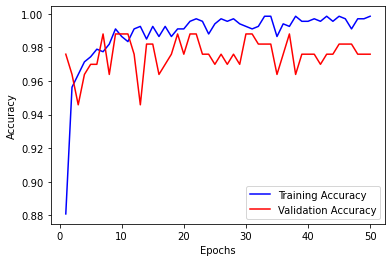

In [43]:
train_acc = training_history.history['binary_accuracy']
val_acc = training_history.history['val_binary_accuracy']

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.plot(np.arange(1,epok +1,1),training_history.history['binary_accuracy'], label='Training Accuracy', color='blue')
plt.plot(np.arange(1,epok +1,1),training_history.history['val_binary_accuracy'], label='Validation Accuracy', color='red')

plt.legend()

plt.show()

Il semble que l'on a gagné à utiliser une nouvelle variable LABEL avec seulement deux classes. Il pourrait être objecté que cette variable LABEL ne se base sur rien de concret mais ce serait occulter le fait que:

- d'une part la variable 'quality' ne présente elle aussi pas de justification à priori 
- d'autre part la variable 'LABEL' a été générée à partir du jeu de donnée, suite à la recherche du meilleur nombre de classe.

Si l'on fait varier le nombre de classe de LABEL, on baisse invariablement en score ce qui tend à démontrer la pertinence de la démarche

In [46]:

score =[]

for i in range(2,10):
    cluster = AgglomerativeClustering(n_clusters = i)
    cluster.fit(features)
    labels = cluster.labels_
    LABEL = pd.Series(labels)
    df_new = pd.concat([df.reset_index().drop(['index'],axis = 1),LABEL],axis=  1).rename(columns={0:'LABEL'})

    FEATURES = df_new.drop(['LABEL','quality'],axis = 1)
    TARGET = df_new['LABEL']

    X_TRAIN,X_TEST,Y_TRAIN,Y_TEST = train_test_split(FEATURES,TARGET,test_size = 0.2)

    scaler = preprocessing.StandardScaler().fit(X_TRAIN)
    X_TRAIN_SCALED = scaler.transform(X_TRAIN)
    X_TEST_SCALED = scaler.transform(X_TEST)

    LOGREG = LogisticRegression()
    LOGREG.fit(X_TRAIN_SCALED,Y_TRAIN)
    score.append(LOGREG.score(X_TEST_SCALED,Y_TEST))

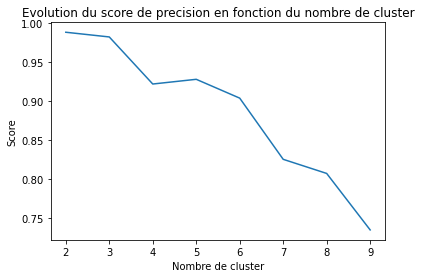

In [47]:
plt.plot([i for i in range(2,10)],score,label ='Score')
plt.title('Evolution du score de precision en fonction du nombre de cluster')
plt.xlabel('Nombre de cluster')
plt.ylabel('Score')
plt.show()

Il est possible de tolérer moins de précision, via l'augmentation du nombre de classe si cela se traduit par une amélioration du chiffre de vente, eu égard à la proposition de fourchette de prix par label correspondant à plusieurs types de consommateurs.

In fine, les classes de "LABEL" vont regrouper des vins dont le gout va dépendre de l'ensemble des variables proposées. Il est attendu que le fait d'avoir regroupé les vins en utilisant l'algorithme est plus pertinent en terme de gout et de variabilité de gout que si cela avait été réalisé manuellement sur la base d'une ou deux variables. 

Il eut été intéressant de fournir les noms des vins de façon à soumettre à des connaisseurs les regroupements proposés. 